# Data Preprocessing and Modeling

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, Adadelta, Adagrad, SGD, RMSprop

import os

***
## Preprocessing

### Create directory paths for image data

In [2]:
data_train_dir = '../chest_xray/train/'
data_test_dir = '../chest_xray/test/'
data_val_dir = '../chest_xray/val/'

In [3]:
# Getting data from directory and reshaping it
train_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_train_dir, target_size=(64,64), batch_size=5216)

Found 5216 images belonging to 2 classes.


In [4]:
# Getting data from directory and reshaping it
test_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_test_dir, target_size=(64,64), batch_size=624)

Found 624 images belonging to 2 classes.


In [5]:
# Getting data from directory and reshaping it
val_generator = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(data_val_dir, target_size=(64,64), batch_size=16)

Found 16 images belonging to 2 classes.


### Review Class Indices

In [6]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [8]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Create datasets

In [9]:
train_images, train_labels = next(train_generator)

In [10]:
test_images, test_labels = next(test_generator)

In [11]:
val_images, val_labels = next(val_generator)

### Preview some images

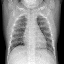

In [12]:
# Checking to see if images were properly uploaded
array_to_img(train_images[0])

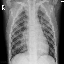

In [13]:
array_to_img(test_images[0])

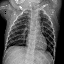

In [14]:
array_to_img(val_images[0])

### Preview shape of data

In [15]:
print('Train Images Shape:', np.shape(train_images))
print('Train Labels Shape:', np.shape(train_labels))
print('Test Images Shape:' , np.shape(test_images))
print('Test Labels Shape:' , np.shape(test_labels))
print('Validation Images Shape:', np.shape(val_images))
print('Validation Labels Shape:', np.shape(val_labels))

Train Images Shape: (5216, 64, 64, 3)
Train Labels Shape: (5216, 2)
Test Images Shape: (624, 64, 64, 3)
Test Labels Shape: (624, 2)
Validation Images Shape: (16, 64, 64, 3)
Validation Labels Shape: (16, 2)


### Transform Image and Label Matrices

In [16]:
train_y = np.reshape(train_labels[:,0], (5216,1))
train_y.shape

(5216, 1)

In [17]:
test_y = np.reshape(test_labels[:,0], (624,1))
test_y.shape

(624, 1)

In [18]:
val_y = np.reshape(val_labels[:,0], (16,1))
val_y.shape

(16, 1)

In [19]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [20]:
train_img.shape

(5216, 12288)

In [21]:
test_img.shape

(624, 12288)

In [22]:
val_img.shape

(16, 12288)

***
## Modeling

### Build a baseline fully connected model

In [23]:
from keras import models
np.random.seed(123)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_1 = baseline_model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 1s 6ms/step - loss: 0.4811 - accuracy: 0.7594 - val_loss: 0.6061 - val_accuracy: 0.7500
Epoch 2/50
163/163 [==============================] - 1s 4ms/step - loss: 0.3276 - accuracy: 0.8675 - val_loss: 0.9453 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 1s 4ms/step - loss: 0.2833 - accuracy: 0.8792 - val_loss: 0.4024 - val_accuracy: 0.8750
Epoch 4/50
163/163 [==============================] - 1s 4ms/step - loss: 0.2340 - accuracy: 0.9036 - val_loss: 0.4326 - val_accuracy: 0.8750
Epoch 5/50
163/163 [==============================] - 1s 4ms/step - loss: 0.2029 - accuracy: 0.9185 - val_loss: 0.3074 - val_accuracy: 0.9375
Epoch 6/50
163/163 [==============================] - 1s 4ms/step - loss: 0.1726 - accuracy: 0.9317 - val_loss: 0.2988 - val_accuracy: 0.8125
Epoch 7/50
163/163 [==============================] - 1s 4ms/step - loss: 0.1680 - accuracy: 0.9317 - val_loss: 0.3959 - val_accuracy: 0.8125
Epoch 

In [25]:
base_train_results = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 3ms/step - loss: 0.0725 - accuracy: 0.9735


In [26]:
base_test_results = baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 7ms/step - loss: 0.9244 - accuracy: 0.7580


In [27]:
base_train_results

[0.07251103222370148, 0.9735429286956787]

In [28]:
base_test_results

[0.9244120717048645, 0.7580128312110901]

So baseline is looking pretty good. The test loss and accuracy is off which worries me, but this is just the baseline so lets see how we can improve this.

### Model 1: Use CNN with regular settings, no regularization or normalization

In [29]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [30]:
# Compile model
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
# Use EarlyStopping to stop model after the validation loss ceases to improve
early_stop = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [32]:
results_1 = model_1.fit(train_images,
                    train_y,
                    epochs=150,
                    callbacks=early_stop,
                    batch_size=500,
                    validation_data=(val_images, val_y))

Epoch 1/150
11/11 [==============================] - 22s 2s/step - loss: 0.6194 - accuracy: 0.7423 - val_loss: 0.7762 - val_accuracy: 0.5000
Epoch 2/150
11/11 [==============================] - 21s 2s/step - loss: 0.5765 - accuracy: 0.7429 - val_loss: 0.8107 - val_accuracy: 0.5000
Epoch 3/150
11/11 [==============================] - 20s 2s/step - loss: 0.5724 - accuracy: 0.7429 - val_loss: 0.8280 - val_accuracy: 0.5000
Epoch 4/150
11/11 [==============================] - 21s 2s/step - loss: 0.5700 - accuracy: 0.7429 - val_loss: 0.8265 - val_accuracy: 0.5000
Epoch 5/150
11/11 [==============================] - 20s 2s/step - loss: 0.5678 - accuracy: 0.7429 - val_loss: 0.8326 - val_accuracy: 0.5000
Epoch 6/150
11/11 [==============================] - 22s 2s/step - loss: 0.5657 - accuracy: 0.7429 - val_loss: 0.8215 - val_accuracy: 0.5000
Epoch 7/150
11/11 [==============================] - 21s 2s/step - loss: 0.5634 - accuracy: 0.7429 - val_loss: 0.8096 - val_accuracy: 0.5000
Epoch 8/150
1

### Evaluate Models

In [33]:
mod1_results_train = model_1.evaluate(train_images, train_y)
mod1_results_train

163/163 [==============================] - 6s 36ms/step - loss: 0.5514 - accuracy: 0.7429


[0.5513514280319214, 0.7429064512252808]

In [34]:
mod1_results_test = model_1.evaluate(test_images, test_y)
mod1_results_test

20/20 [==============================] - 1s 43ms/step - loss: 0.6793 - accuracy: 0.6250


[0.67933189868927, 0.625]

### Create Function to plot Loss and Accuracy of Model

In [37]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

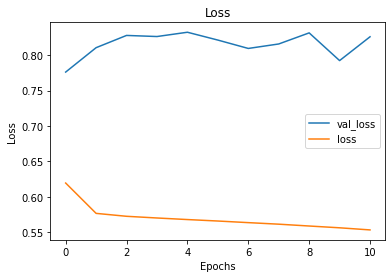

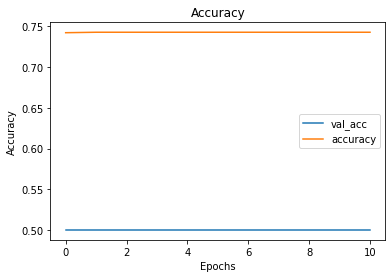

In [38]:
visualize_training_results(results_1)

### Confusion Matrix, Classification Report

In [39]:
# Create a function to plot confusion matrices
def plot_confusion_matrix(labels, preds):
    cnf_matrix = confusion_matrix(labels, preds)
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    y = train_generator.class_indices
    class_names = set(y) 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cnf_matrix.max() / 2. #
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.colorbar()
    plt.show()

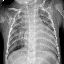

In [40]:
# Use sample image to test model predictions
sample_image = array_to_img(train_images[100])
sample_image

In [41]:
pred_1 = model_1.predict(val_images)

In [46]:
# Classification report
class_report_1 = classification_report(val_y, pred_1.round())
print(class_report_1)

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         8
         1.0       0.00      0.00      0.00         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



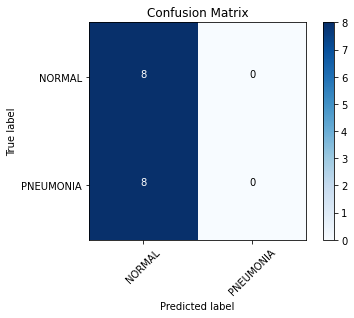

In [48]:
plot_confusion_matrix(val_y, pred_1.round())

In [49]:
np.argmax(pred_1[0])

0

In [50]:
val_y[0]

array([1.], dtype=float32)

## Model 2: Tuning and Optimizing 

In [51]:
# First create a dictionary of optimizers 
optimizers = {"RMSprop": {"optimizer": RMSprop(), "color":"blue"},
                  "adam_01": {"optimizer": Adam(lr=0.01), "color":"red"},
                  "sgd": {"optimizer": SGD(), "color":"purple"},
                  "adadelta": {"optimizer": Adadelta(), "color":"pink"},
                  "adagrad": {"optimizer": Adagrad(), "color":"yellow"}}

In [ ]:
# Now iterate thru the optimizer dictionary and build CNN with each optimizer
for optimizer, x in optimizers.items():
    print('Testing', optimizer)
    
    model_2 = Sequential()
    
    model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
    model_2.add(layers.MaxPooling2D((2, 2)))

    model_2.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model_2.add(layers.MaxPooling2D((2, 2)))

    model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model_2.add(layers.MaxPooling2D((2, 2)))

    model_2.add(layers.Flatten())
    model_2.add(layers.Dense(64, activation='relu'))
    model_2.add(layers.Dense(1, activation='sigmoid'))
    
    model_2.compile(optimizer = x['optimizer'],
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    results_2 = model_2.fit(train_images,
                    train_y,
                    epochs=20,
                    callbacks=early_stop,
                    batch_size=500,
                    validation_data=(val_images, val_y))